<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/tutorial_fixes/tutorials/W2D3_ModernRecurrentNeuralNetworks/W2D3_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Modern RNNs and their variants
**Week 2, Day 3: Modern RNNs**

**By Neuromatch Academy**

__Content creators:__ Bhargav Srinivasa Desikan, Anis Zahedifard, James Evans

__Content reviewers:__ Lily Cheng, Melvin Selim Atay, Ezekiel Williams

__Production editors:__ Roberto Guidotti, Spiros Chavlis

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial objectives

In this tutorial you will learn about:
1. Modern Recurrent Neural Networks and their use
2. Long Short-Term Memory (LSTM), Gated Recurrent Unit (GRU) and the memory cell
3. Sequence to Sequence and Encoder-Decoder Networks
4. Models of attention for text classification

In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in this tutorials
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/n23hy/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

We will use the IMDB dataset, which consists of a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. We will use torchtext to download the dataset and prepare it for training, validation and testing. Our goal is to build a model that performs binary classification between positive and negative movie reviews.

We use `fix_length` argument to pad sentences of length less than `sentence_length` or truncate sentences of length greater than `sentence_length`. 

In [2]:
# @title Install dependecies
!pip install --upgrade gensim --quiet
!pip install torchtext==0.4.0 --quiet
!pip install unidecode --quiet
!pip install d2l --quiet
!pip install nltk --quiet

     |████████████████████████████████| 23.9 MB 1.3 MB/s 
     |████████████████████████████████| 53 kB 1.2 MB/s 
     |████████████████████████████████| 241 kB 8.1 MB/s 
     |████████████████████████████████| 83 kB 1.5 MB/s 


In [3]:
# Imports
import math
import time
import nltk
import torch
import random
import collections

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from d2l import torch as d2l
from torch.autograd import Variable
from torchtext import data, datasets
from torch.nn import functional as F

In [4]:
# @title Figure Settings
import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [5]:
# @title Download the dataset
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('webtext')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.


True

In [6]:
# @title Helper functions

def plot_train_val(x, train, val, train_label,
                   val_label, title, y_label,
                   color):

  plt.plot(x, train, label=train_label, color=color)
  plt.plot(x, val, label=val_label, color=color, linestyle='--')
  plt.legend(loc='lower right')
  plt.xlabel('epoch')
  plt.ylabel(y_label)
  plt.title(title)


def count_parameters(model):
  parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return parameters


def init_weights(m):
  if type(m) in (nn.Linear, nn.Conv1d):
    nn.init.xavier_uniform_(m.weight)


#  Dataset Loader
def load_dataset(sentence_length=50, batch_size=32, seed=522):

  TEXT = data.Field(sequential=True,
                    tokenize=nltk.word_tokenize,
                    lower=True,
                    include_lengths=True,
                    batch_first=True,
                    fix_length=sentence_length)
  LABEL = data.LabelField(dtype=torch.float)

  train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

  # If no specific vector embeddings are specified,
  # Torchtext initializes random vector embeddings
  # which would get updated during training through backpropagation.
  TEXT.build_vocab(train_data)
  LABEL.build_vocab(train_data)

  train_data, valid_data = train_data.split(split_ratio=0.7,
                                            random_state=random.seed(seed))
  train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data),
                                                                  batch_size=batch_size, sort_key=lambda x: len(x.text),
                                                                  repeat=False, shuffle=True)
  vocab_size = len(TEXT.vocab)

  print(f"Data loading is completed. Sentence length: {sentence_length}, "
        f"Batch size: {batch_size}, and seed: {seed}")

  return TEXT, vocab_size, train_iter, valid_iter, test_iter


def text_from_dict(arr, dictionary):
  text = []
  for element in arr:
    text.append(dictionary[element])
  return text


def view_data(TEXT, train_iter):
  for idx, batch in enumerate(train_iter):
    text = batch.text[0]
    target = batch.label

    for itr in range(25, 30):
      print('Review: ', ' '.join(text_from_dict(text[itr], TEXT.vocab.itos)))
      print('Label: ', int(target[itr].item()), '\n')

    print('[0: Negative Review, 1: Positive Review]')
    if idx==0:
      break


# Training function
def train(model, device, train_iter, valid_iter, epochs, learning_rate):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  for epoch in range(epochs):
    #train
    model.train()
    running_loss = 0.
    correct, total = 0, 0
    steps = 0

    for idx, batch in enumerate(train_iter):
      text = batch.text[0]
      # print(type(text), text.shape)
      target = batch.label
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      # add micro for coding training loop
      optimizer.zero_grad()
      output = model(text)

      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      steps += 1
      running_loss += loss.item()

      # get accuracy
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

    train_loss.append(running_loss/len(train_iter))
    train_acc.append(correct/total)

    print(f'Epoch: {epoch + 1}, '
          f'Training Loss: {running_loss/len(train_iter):.4f}, '
          f'Training Accuracy: {100*correct/total: .2f}%')

    # evaluate on validation data
    model.eval()
    running_loss = 0.
    correct, total = 0, 0

    with torch.no_grad():
      for idx, batch in enumerate(valid_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(text)

        loss = criterion(output, target)
        running_loss += loss.item()

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    validation_loss.append(running_loss/len(valid_iter))
    validation_acc.append(correct/total)

    print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, '
           f'Validation Accuracy: {100*correct/total: .2f}%')

  return train_loss, train_acc, validation_loss, validation_acc


# Testing function
def test(model, device, test_iter):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, batch in enumerate(test_iter):
      text = batch.text[0]
      target = batch.label
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      outputs = model(text)
      _, predicted = torch.max(outputs, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

    acc = 100 * correct / total
    return acc

In [7]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [8]:
# @title Set device (GPU or CPU). Execute `set_device()`
# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [9]:
DEVICE = set_device()
SEED = 2021
set_seed(seed=SEED)

GPU is enabled in this notebook.
Random seed 2021 has been set.


---
# Section 1: Recurrent Neural Networks (RNNs)

In [10]:
# @title Video 1: Recurrent Neural Networks
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Ng41177az", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"hIHocwdyY7M", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

Recurrent neural networks, or RNNs , are a family of neural networks for processing sequential data. Just as a convolutional network is specialized for processing a grid of values X such as an image, a recurrent neural network is specialized for processing a sequence of values. RNNs prove useful in many scenarios where other deep learning models are not effective.

* Not all problems can be converted into one with fixed length inputs and outputs.


* The deep learning models we have seen so far pick samples randomly. This might not be the best strategy for a task of understanding meaning from a piece of text. Words in a text occur in a sequence and therefore cannot be permuted randomly to get the meaning.

The following provides more data than the video (but can be skipped for now). For more detail, see the sources, the [deep learning book](https://www.deeplearningbook.org/contents/rnn.html), and [d2l.ai](https://d2l.ai/chapter_recurrent-neural-networks/rnn.html)

When the recurrent network is trained to perform a task that requires predicting the future from the past, the network typically learns to use a hidden state at time step $t$, $H_t$ as a kind of lossy summary of the task-relevant aspects of the past sequence of inputs up to $t$. This summary is in general necessarily lossy, since it maps an arbitrary length sequence $(X_t, X_{t-1}, X_{t-2}, . . . , X_{2}, X_{1})$ to a ﬁxed length vector $H_t$.

We can represent the unfolded recurrence after $t$ steps with a function $G_t$:

\begin{align}
H_t &= G_t(X_t, X_{t-1}, X_{t-2}, \dots, X_{2}, X_{1}) \\
&= f(H_{t−1}, X_{t}; \theta)
\end{align}

where $\theta$ denotes the model parameters, i.e., weights and biases.

<img width=700 src="https://blog.floydhub.com/content/images/2019/04/rnn-2.gif"> 

The function $g_t$ takes the whole past sequence $(X_t, X_{t-1}, X_{t-2}, . . . , X_{2}, X_{1})$ as input and produces the current state, but the unfolded recurrent structure allows us to factorize $g_t$ into repeated application of a function f. The unfolding process thus introduces two major advantages:

* Regardless of the sequence length, the learned model always has the same input size, because it is speciﬁed in terms of transition from one state to another state, rather than speciﬁed in terms of a variable-length history of states.

* It is possible to use the same transition function $f$ with the same parameters at every time step.


We will now formally write down the equations of a recurrent unit.


Assume that we have a minibatch of inputs $X_t \in R^{nxd}$ at time step $t$ . In other words, for a minibatch of $n$ sequence examples, each row of $X_t$  corresponds to one example at time step $t$ from the sequence. Next, we denote by $H_t \in R^{nxh}$ the hidden variable of time step $t$. Unlike the MLP, here we save the hidden variable $H_{t-1}$ from the previous time step and introduce a new weight parameter $W_{hh} \in R^{hxh}$ to describe how to use the hidden variable of the previous time step in the current time step. Specifically, the calculation of the hidden variable of the current time step is determined by the input of the current time step together with the hidden variable of the previous time step:

\begin{equation}
H_t = \phi(X_t W_{xh} + H_{t-1}W_{hh} + b_h)
\end{equation}

For time step $t$, the output of the output layer is similar to the computation in the MLP:

\begin{equation}
O_t = H_t W_{hq} + b_q
\end{equation}
 
Parameters of the RNN include the weights $W_{xh} \in R^{dxh}, W_{hh} \in R^{hxh}$ , and the bias $b_h \in R^{1xh}$ of the hidden layer, together with the weights $W_{hq} \in R^{hxq}$ and the bias $b_q \in R^{1xq}$ of the output layer. It is worth mentioning that even at different time steps, RNNs always use these model parameters. Therefore, the parameterization cost of an RNN does not grow as the number of time steps increases.

<img width=700 align="center" src="https://d2l.ai/_images/rnn.svg">

## Section 1.1: Load and View of the dataset

Let us first load the dataset using the helper function `load_data`, which takes three arguments; the `sentence_length`, `batch_size`, and the `seed`. The default values are 50, 32, and 522, respectively. Execute the cell below to load the data.

In [11]:
# @markdown Dataset Loading with default params
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(seed=SEED)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 82.0MB/s]


Data loading is completed. Sentence length: 50, Batch size: 32, and seed: 2021


Now, let's view the data!

In [12]:
# @markdown Visualize dataset
view_data(TEXT, train_iter)

Review:  i love this show and my 11 year-old daughter and i love watching it together . it teaches good old fashioned values in a fun , adventuresome and entertaining way ( albeit with a somewhat predictable story most of the time ) . it 's also really fun to make
Label:  1 

Review:  personally , i think that the film was done very professionally , i loved the choreography and the acting . the plot is also gripping and mysterious . the film itself is very emotional , and what i liked about it most is that it makes you think afterwards .
Label:  1 

Review:  this show is totally worth watching . it has the best cast of talent i have seen in a very long time . the premise of the show is unique and fresh ( i guess the executives at abc are not used too that , as it was not another
Label:  1 

Review:  the movie is basically the story of a russian prostitute 's return to her home village for the funeral of a sister/friend . there are a couple of other minor story lines that might actually

### Coding Exercise 1.1: Vanilla RNN

Now it's your turn to write a Vanilla RNN using PyTorch.

* Once again we will use `nn.Embedding`. You are given the `vocab_size` which is the size of the dictionary of embeddings, and the `embed_size` which is the size of each embedding vector.  

* Add 2 [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) layers. This would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results.

* Determine the size of inputs and outputs to the fully-connected layer.

In [13]:
class VanillaRNN(nn.Module):
  def __init__(self, layers, output_size, hidden_size, vocab_size, embed_size,
               device):
    super(VanillaRNN, self).__init__()
    self.n_layers= layers
    self.hidden_size = hidden_size
    self.device = device
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the Vanilla RNN components")
    ####################################################################
    # Define the embedding
    self.embeddings = ...
    # Define the RNN layer
    self.rnn = ...
    # Define the fully connected layer
    self.fc = ...


  def forward(self, inputs):
    input = self.embeddings(inputs)
    input = input.permute(1, 0, 2)
    h_0 = Variable(torch.zeros(2, input.size()[1],
                               self.hidden_size).to(self.device))
    output, h_n = self.rnn(input, h_0)
    h_n = h_n.permute(1, 0, 2)
    h_n = h_n.contiguous().view(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
    logits = self.fc(h_n)

    return logits


## Uncomment to test VanillaRNN class
# sampleRNN = VanillaRNN(2, 10, 50, 1000, 300, DEVICE)
# print(sampleRNN)

In [14]:
# to_remove solution
class VanillaRNN(nn.Module):
  def __init__(self, layers, output_size, hidden_size, vocab_size, embed_size,
               device):
    super(VanillaRNN, self).__init__()
    self.n_layers= layers
    self.hidden_size = hidden_size
    self.device = device
    # Define the embedding
    self.embeddings = nn.Embedding(vocab_size, embed_size)
    # Define the RNN layer
    self.rnn = nn.RNN(embed_size, hidden_size, self.n_layers)
    # Define the fully connected layer
    self.fc = nn.Linear(self.n_layers *hidden_size, output_size)

  def forward(self, inputs):
    input = self.embeddings(inputs)
    input = input.permute(1, 0, 2)
    h_0 = Variable(torch.zeros(2, input.size()[1],
                               self.hidden_size).to(self.device))
    output, h_n = self.rnn(input, h_0)
    h_n = h_n.permute(1, 0, 2)
    h_n = h_n.contiguous().view(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
    logits = self.fc(h_n)

    return logits


## Uncomment to test VanillaRNN class
sampleRNN = VanillaRNN(2, 10, 50, 1000, 300, DEVICE)
print(sampleRNN)

VanillaRNN(
  (embeddings): Embedding(1000, 300)
  (rnn): RNN(300, 50, num_layers=2)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)


```
VanillaRNN(
  (embeddings): Embedding(1000, 300)
  (rnn): RNN(300, 50, num_layers=2)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)
```

## Section 1.2: Train and test the network

Random seed 2021 has been set.
Epoch: 1, Training Loss: 0.6997, Training Accuracy:  50.30%
Validation Loss: 0.6961, Validation Accuracy:  50.48%
Epoch: 2, Training Loss: 0.6908, Training Accuracy:  52.94%
Validation Loss: 0.6948, Validation Accuracy:  51.75%
Epoch: 3, Training Loss: 0.6860, Training Accuracy:  54.89%
Validation Loss: 0.6935, Validation Accuracy:  52.19%
Epoch: 4, Training Loss: 0.6754, Training Accuracy:  57.53%
Validation Loss: 0.6775, Validation Accuracy:  57.97%
Epoch: 5, Training Loss: 0.6506, Training Accuracy:  62.18%
Validation Loss: 0.6666, Validation Accuracy:  60.71%
Epoch: 6, Training Loss: 0.6258, Training Accuracy:  65.47%
Validation Loss: 0.6616, Validation Accuracy:  61.96%
Epoch: 7, Training Loss: 0.5954, Training Accuracy:  68.57%
Validation Loss: 0.6505, Validation Accuracy:  64.07%
Epoch: 8, Training Loss: 0.5655, Training Accuracy:  71.30%
Validation Loss: 0.6451, Validation Accuracy:  64.65%
Epoch: 9, Training Loss: 0.5335, Training Accuracy:  74.0

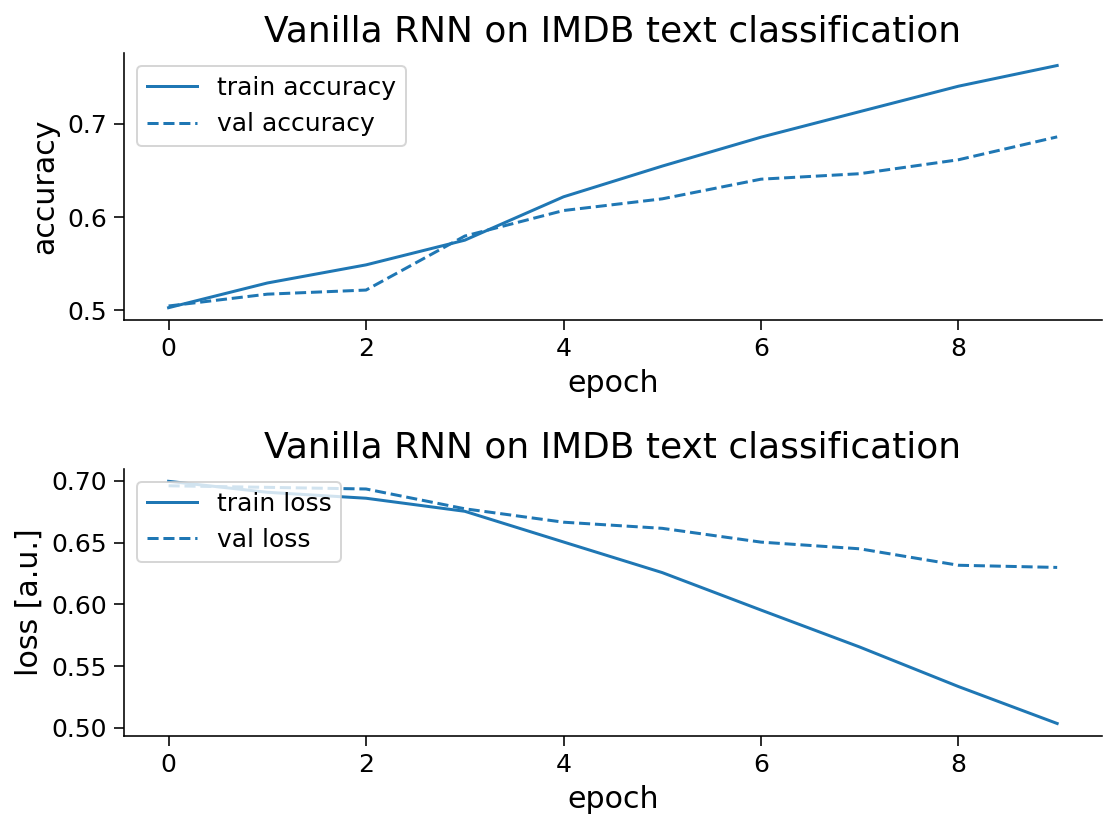

In [15]:
# Model hyperparamters
learning_rate = 0.0002
layers = 2
output_size = 2
hidden_size = 50  # 100
embedding_length = 100
epochs = 10


# Initialize model, training and testing
set_seed(SEED)
vanilla_rnn_model = VanillaRNN(layers, output_size, hidden_size, vocab_size,
                               embedding_length, DEVICE)
vanilla_rnn_model.to(DEVICE)
vanilla_rnn_start_time = time.time()
vanilla_train_loss, vanilla_train_acc, vanilla_validation_loss, vanilla_validation_acc = train(vanilla_rnn_model,
                                                                                               DEVICE,
                                                                                               train_iter,
                                                                                               valid_iter,
                                                                                               epochs,
                                                                                               learning_rate)
print("--- Time taken to train = %s seconds ---" % (time.time() - vanilla_rnn_start_time))
test_accuracy = test(vanilla_rnn_model, DEVICE, test_iter)
print(f'Test Accuracy: {test_accuracy} with len=50\n')

# Number of model parameters
print(f'Number of parameters = {count_parameters(vanilla_rnn_model)}')


# Plot accuracy curves
plt.figure()
plt.subplot(211)
plot_train_val(np.arange(0, epochs), vanilla_train_acc, vanilla_validation_acc,
               'train accuracy', 'val accuracy',
               'Vanilla RNN on IMDB text classification', 'accuracy',
               color='C0')
plt.legend(loc='upper left')
plt.subplot(212)
plot_train_val(np.arange(0, epochs), vanilla_train_loss,
               vanilla_validation_loss,
               'train loss', 'val loss',
               'Vanilla RNN on IMDB text classification',
               'loss [a.u.]',
               color='C0')
plt.legend(loc='upper left')
plt.show()

### Change the input length

Now let's increase the `sentence_length` to see how RNN performs when long reviews are allowed..


In [16]:
# @markdown Load dataset with `sentence_length=200`
TEXT_long, vocab_size_long, train_iter_long, valid_iter_long, test_iter_long = load_dataset(sentence_length=200)

Data loading is completed. Sentence length: 200, Batch size: 32, and seed: 522


### Re-run the network

In [17]:
# Model hyperparamters
learning_rate = 0.0002
layers = 2
output_size = 2
hidden_size = 50  # 100
embedding_length = 100
epochs = 10

# Initialize model, training, testing
set_seed(SEED)
vanilla_rnn_model_long = VanillaRNN(layers, output_size, hidden_size,
                                    vocab_size_long, embedding_length, DEVICE)
vanilla_rnn_model_long.to(DEVICE)
vanilla_rnn_start_time_long = time.time()
vanilla_train_loss_long, vanilla_train_acc_long, vanilla_validation_loss_long, vanilla_validation_acc_long = train(vanilla_rnn_model_long,
                                                                                                                   DEVICE,
                                                                                                                   train_iter_long,
                                                                                                                   valid_iter_long,
                                                                                                                   epochs,
                                                                                                                   learning_rate)
print("--- Time taken to train = %s seconds ---" % (time.time() - vanilla_rnn_start_time_long))
test_accuracy = test(vanilla_rnn_model_long, DEVICE, test_iter_long)
print(f'Test Accuracy: {test_accuracy} with len=200\n')

# Number of parameters
print(f'\nNumber of parameters = {count_parameters(vanilla_rnn_model_long)}')

Random seed 2021 has been set.
Epoch: 1, Training Loss: 0.6994, Training Accuracy:  49.75%
Validation Loss: 0.6958, Validation Accuracy:  50.15%
Epoch: 2, Training Loss: 0.6927, Training Accuracy:  51.51%
Validation Loss: 0.6952, Validation Accuracy:  50.17%
Epoch: 3, Training Loss: 0.6898, Training Accuracy:  52.88%
Validation Loss: 0.6950, Validation Accuracy:  50.57%
Epoch: 4, Training Loss: 0.6860, Training Accuracy:  53.95%
Validation Loss: 0.6958, Validation Accuracy:  50.92%
Epoch: 5, Training Loss: 0.6802, Training Accuracy:  54.91%
Validation Loss: 0.7014, Validation Accuracy:  50.81%
Epoch: 6, Training Loss: 0.6724, Training Accuracy:  56.36%
Validation Loss: 0.7064, Validation Accuracy:  50.92%
Epoch: 7, Training Loss: 0.6636, Training Accuracy:  57.41%
Validation Loss: 0.7098, Validation Accuracy:  50.72%
Epoch: 8, Training Loss: 0.6507, Training Accuracy:  59.42%
Validation Loss: 0.7210, Validation Accuracy:  50.75%
Epoch: 9, Training Loss: 0.6381, Training Accuracy:  60.6

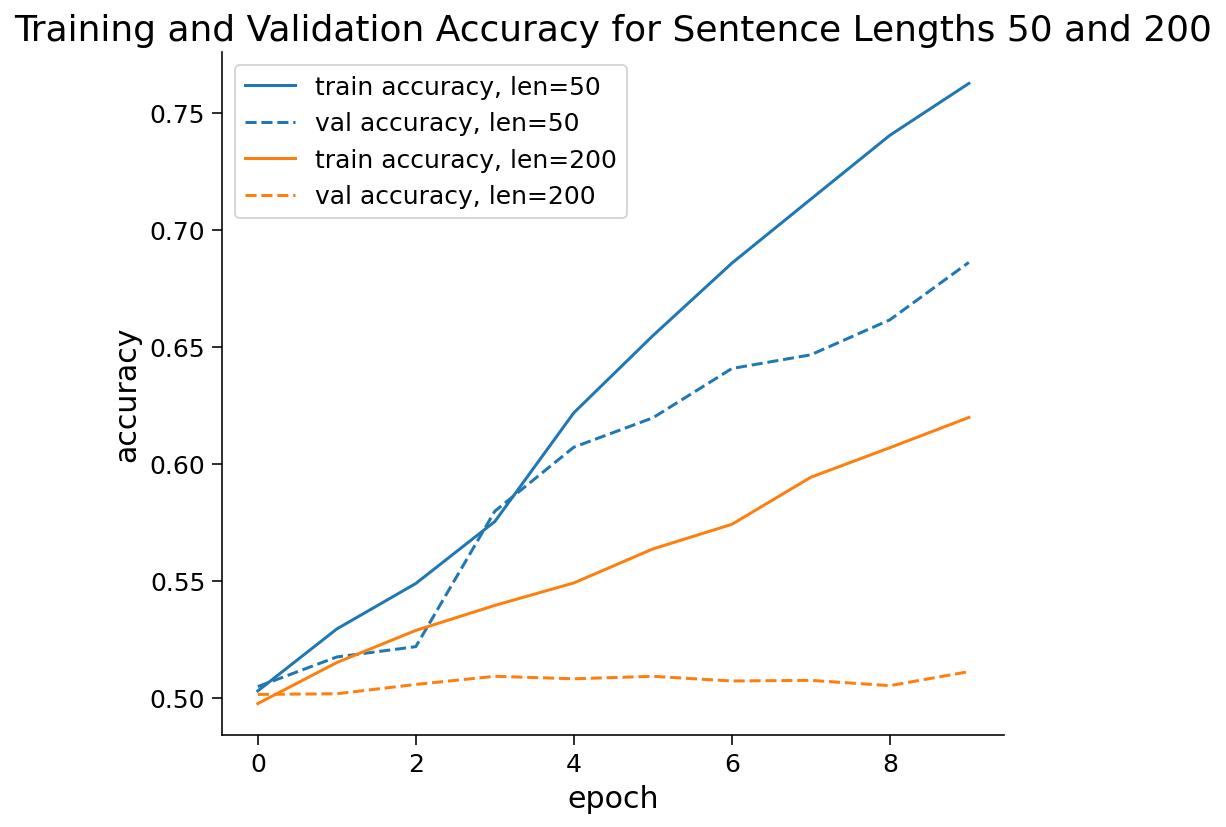

In [18]:
# Compare accuracies of model trained on different sentence lengths
plot_train_val(np.arange(0, epochs), vanilla_train_acc,
               vanilla_validation_acc,
               'train accuracy, len=50', 'val accuracy, len=50',
               '', 'accuracy',
               color='C0')
plot_train_val(np.arange(0, epochs), vanilla_train_acc_long,
               vanilla_validation_acc_long,
               'train accuracy, len=200', 'val accuracy, len=200',
               'Training and Validation Accuracy for Sentence Lengths 50 and 200',
               'accuracy',
               color='C1')
plt.legend(loc='upper left')
plt.show()

## Section 1.3: Architectures

In [19]:
# @title Video 2: Bidirectional RNNs
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1X64y1x7BA", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"TpgJwqB4i1c", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

RNN models are mostly used in the fields of natural language processing and speech recognition. Below are types of RNNs. Depending on which outputs we use, RNN can be used for variety of tasks. The text classification problem we solved was an instance of the many to one architecture. Write down the applications of other architectures. 


<img width=900 src="https://blog.floydhub.com/content/images/2019/04/karpathy.jpeg">

## Section 1.4: Vanishing and Exploding Gradients

For an RNN to learn via backprop through time on a loss calculated at time $T$, $\mathcal{L}_T$, with respect to an input $t$ time steps in the past, the RNN weights must be updated based on how they contributed to the hidden state at this past time step. This contribution is learned through the term $\frac{\partial h_{-t}}{\partial W}$, in the gradient of the loss, $\frac{\partial\mathcal{L}_T}{\partial W}$.

However, because one has to backpropagate error through $t-1$ hidden states, $\frac{\partial h_{-t}}{\partial W}$ is multiplied by $\prod_{i=0}^{t-1} \frac{\partial{h_i}}{\partial{h_{i-1}}}$ in the expression for $\frac{\partial\mathcal{L}_T}{\partial W}$, which are summarized mathematically:

\begin{equation}
\frac{\partial{\mathcal{L}_T}}{\partial{W}} \propto \frac{\partial h_t }{ \partial W} + \sum_{k=0}^{t-1} \left( \prod_{i=k+1}^{t} \frac{\partial{h_i}}{\partial{h_{i-1}}} \right) \frac{\partial{h_k}}{\partial{W}}
\end{equation}

The product term leads to two common problems during the backpropagation of time-series data:

* *Vanishing gradients*, *if* $ \left| \left| \frac{\partial{h_i}}{\partial{h_{i-1}}} \right| \right|_2 < 1$


* *Exploding gradients*, *if* $ \left| \left| \frac{\partial{h_i}}{\partial{h_{i-1}}} \right| \right|_2 > 1$

Given a sufficiently long sequence, the gradients get multiplied by the weight matrix at every time step. If the weight matrix contains very small values, then the norm of gradients will become smaller and smaller exponentially, the so-called **vanishing gradient** problem. On the other hand, if we have a weight matrix with very large values, the gradients will increase exponentially, leading to the **exploding gradients** problem: where the weights diverge at the update step.

An example that has the vanishing gradient problem:

The input is the characters from a *C* Program. The system will tell whether it is a syntactically correct program. A syntactically correct program should have a valid number of braces and parentheses. Thus, the network should remember how many open parentheses and braces there are to check, and whether we have closed them all. The network has to store such information in hidden states like a counter. However, because of vanishing gradients, it will fail to preserve such information in a long program.

---
# Section 2: LSTM, GRU and Memory Cell

In [20]:
# @title Video 3: LSTM, GRU & The Memory Cells
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Zq4y1X7kj", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"qC7O-2sXLAU", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Section 2.1: Architecture

The core idea behind an LSTM is the cell state $C_t$ that runs along all the LSTM units in a layer, and gets updated along the way. These updates are possible through "gates". Gates are made out of a sigmoid neural net layer and a pointwise multiplication operation. 

Each LSTM unit performs the following distinct steps using the input $x_t$, current cell state $C_t$ and previous hidden state $h_{t-1}$:

* Forget Gate: *Should I throw away information from this cell?*

\begin{equation}
f_t = \sigma (W_f \cdot [h_{t-1}, x_t] + b_f)
\end{equation}

* Input Gate:
    * *Should I add new values to this cell?*
      \begin{equation}
      i_t = \sigma (W_i \cdot [h_{t-1}, x_t] + b_i)
      \end{equation}
    * *What new candidate values should I store?*
      \begin{equation}
      \tilde{C}_t = tanh (W_C \cdot [h_{t-1}, x_t] + b_C)
      \end{equation}

* Update cell state: *Forget things from the past and add new things from the candidates*
  \begin{equation}
  C_t = (f_t \cdot C_{t-1}) + (i_t \cdot \tilde{C}_t)
  \end{equation}

* Output Gate: 
    * *What information should I output?*
      \begin{equation}
      o_t = \sigma (W_o \cdot [h_{t-1}, x_t] + b_o)
      \end{equation}
    * *How much of the cell state should I store in the hidden state?*
      \begin{equation}
      h_t = o_t \cdot tanh(C_t)
      \end{equation}

The architecture can be summarized by the diagram below:
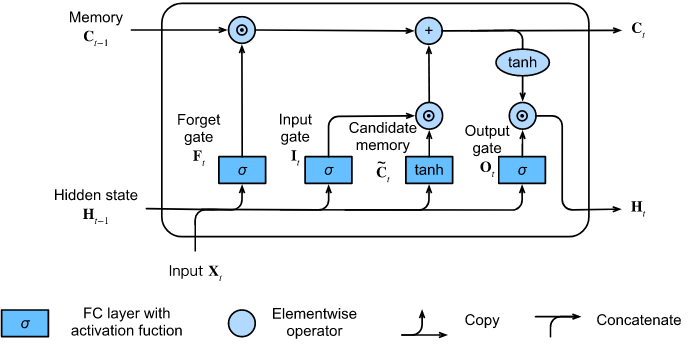

### Coding Exercise 2.1: Implementing LSTM

It is now your turn to build an LSTM network in PyTorch. Feel free to refer to the documentation here: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM . 

* Once again we will use `nn.Embedding`. You are given the `vocab_size` and the `embed_size`.
* Add the [`LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) layers. 
* Define a dropout layer of 0.5. 
* Determine the size of inputs and outputs to the fully-connected layer.
* Pay special attention to the shapes of your inputs and outputs as you write the forward function.



In [21]:
class LSTM(nn.Module):
  def __init__(self, layers, output_size, hidden_size, vocab_size, embed_size,
               device):
    super(LSTM, self).__init__()
    self.n_layers = layers
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.device = device
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("LSTM Init")
    ####################################################################
    # Define the word embeddings
    self.word_embeddings = ...
    # Define the dropout layer
    self.dropout = ...
    # Define the lstm layer
    self.lstm = ...
    # Define the fully-connected layer
    self.fc = ...


  def forward(self, input_sentences):
    """Hint: Make sure the shapes of your tensors match the requirement"""
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("LSTM Forward")
    ####################################################################
    # Embeddings
    # `input` shape: (`num_steps`, `batch_size`, `num_hiddens`)
    input = ...

    hidden = (torch.randn(self.n_layers, input.shape[1],
                          self.hidden_size).to(self.device),
              torch.randn(self.n_layers, input.shape[1],
                          self.hidden_size).to(self.device))
    # Dropout for regularization
    input = self.dropout(input)
    # LSTM
    output, hidden = ...

    h_n = hidden[0].permute(1, 0, 2)
    h_n = h_n.contiguous().view(h_n.shape[0], -1)

    logits = self.fc(h_n)

    return logits


## Uncomment to run
# sampleLSTM = LSTM(3, 10, 100, 1000, 300, DEVICE)
# print(sampleLSTM)

In [22]:
# to_remove solution
class LSTM(nn.Module):
  def __init__(self, layers, output_size, hidden_size, vocab_size, embed_size,
               device):
    super(LSTM, self).__init__()
    self.n_layers = layers
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.device = device
    # Define the word embeddings
    self.word_embeddings = nn.Embedding(vocab_size, embed_size)
    # Define the dropout layer
    self.dropout = nn.Dropout(0.5)
    # Define the lstm layer
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=self.n_layers)
    # Define the fully-connected layer
    self.fc = nn.Linear(self.n_layers*self.hidden_size, output_size)


  def forward(self, input_sentences):
    # Embeddings
    # `input` shape: (`num_steps`, `batch_size`, `num_hiddens`)
    input = self.word_embeddings(input_sentences).permute(1, 0, 2)

    hidden = (torch.randn(self.n_layers, input.shape[1],
                          self.hidden_size).to(self.device),
              torch.randn(self.n_layers, input.shape[1],
                          self.hidden_size).to(self.device))
    # Dropout for regularization
    input = self.dropout(input)
    # LSTM
    output, hidden = self.lstm(input, hidden)

    h_n = hidden[0].permute(1, 0, 2)
    h_n = h_n.contiguous().view(h_n.shape[0], -1)

    logits = self.fc(h_n)

    return logits


## Uncomment to run
sampleLSTM = LSTM(3, 10, 100, 1000, 300, DEVICE)
print(sampleLSTM)

LSTM(
  (word_embeddings): Embedding(1000, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 100, num_layers=3)
  (fc): Linear(in_features=300, out_features=10, bias=True)
)


```
LSTM(
  (word_embeddings): Embedding(1000, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 100, num_layers=3)
  (fc): Linear(in_features=300, out_features=10, bias=True)
)
```

Random seed 2021 has been set.
Epoch: 1, Training Loss: 0.6952, Training Accuracy:  50.37%
Validation Loss: 0.6934, Validation Accuracy:  51.29%
Epoch: 2, Training Loss: 0.6935, Training Accuracy:  51.08%
Validation Loss: 0.6926, Validation Accuracy:  51.13%
Epoch: 3, Training Loss: 0.6926, Training Accuracy:  51.46%
Validation Loss: 0.6921, Validation Accuracy:  51.40%
Epoch: 4, Training Loss: 0.6915, Training Accuracy:  52.07%
Validation Loss: 0.6912, Validation Accuracy:  51.97%
Epoch: 5, Training Loss: 0.6901, Training Accuracy:  53.39%
Validation Loss: 0.6892, Validation Accuracy:  52.84%
Epoch: 6, Training Loss: 0.6834, Training Accuracy:  55.92%
Validation Loss: 0.6749, Validation Accuracy:  58.25%
Epoch: 7, Training Loss: 0.6715, Training Accuracy:  58.75%
Validation Loss: 0.6701, Validation Accuracy:  58.95%
Epoch: 8, Training Loss: 0.6589, Training Accuracy:  60.98%
Validation Loss: 0.6564, Validation Accuracy:  61.55%
Epoch: 9, Training Loss: 0.6459, Training Accuracy:  63.2

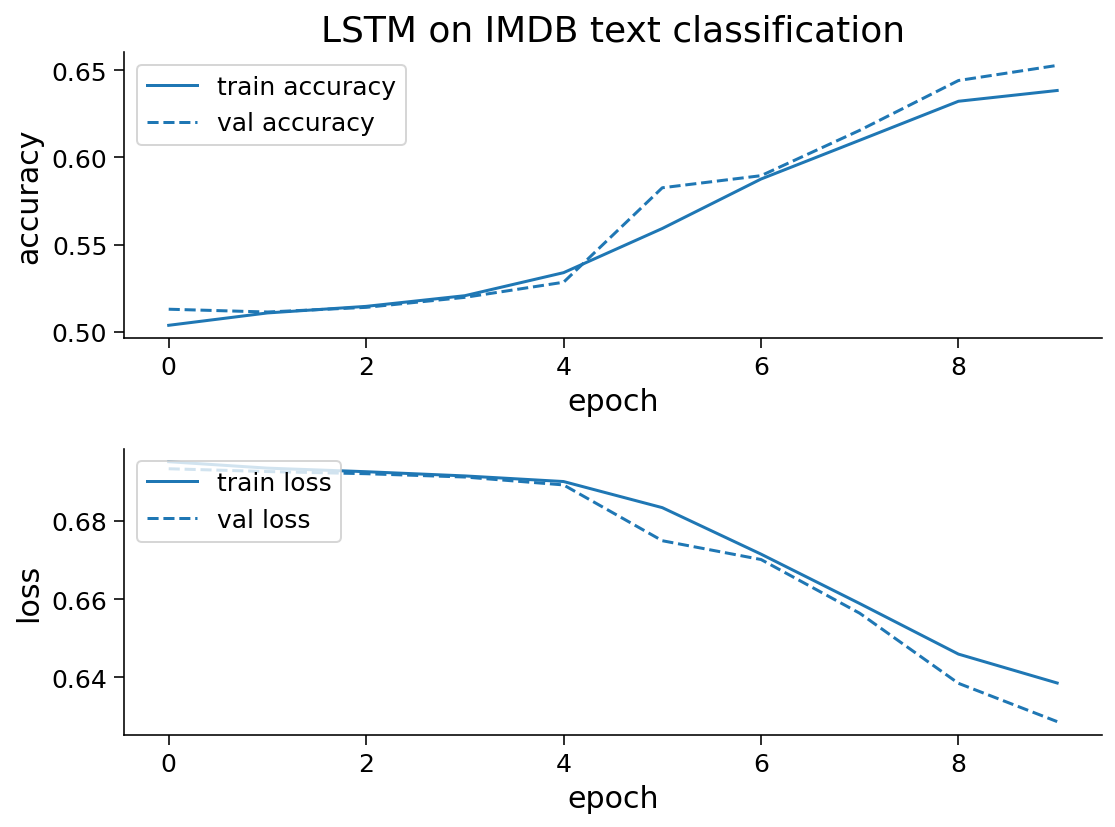

In [23]:
# Hyperparameters
learning_rate = 0.0003
layers = 2
output_size = 2
hidden_size = 16
embedding_length = 100
epochs = 10

# Model, training, testing
set_seed(SEED)
lstm_model = LSTM(layers, output_size, hidden_size, vocab_size,
                  embedding_length, DEVICE)
lstm_model.to(DEVICE)
lstm_train_loss, lstm_train_acc, lstm_validation_loss, lstm_validation_acc = train(lstm_model,
                                                                                   DEVICE,
                                                                                   train_iter,
                                                                                   valid_iter,
                                                                                   epochs,
                                                                                   learning_rate)
test_accuracy = test(lstm_model, DEVICE, test_iter)
print(f'\n\nTest Accuracy: {test_accuracy} of the LSTM model\n')

# Plotting accuracy curve
plt.figure()
plt.subplot(211)
plot_train_val(np.arange(0, epochs), lstm_train_acc, lstm_validation_acc,
               'train accuracy',
               'val accuracy',
               'LSTM on IMDB text classification',
               'accuracy',
               color='C0')
plt.legend(loc='upper left')
plt.subplot(212)
plot_train_val(np.arange(0, epochs), lstm_train_loss, lstm_validation_loss,
               'train loss',
               'val loss',
               '',
               'loss',
               color='C0')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Section 2.2: Gated Recurrent Units (GRU)

The GRU architecture looks very similar to the LSTM, and is often used as an alternative to the traditional LSTM. It also contains some variations that reduce it's complexity. For example, it combines the forget and input gates into a single “update gate”; it contains a "hidden state" but not a "cell state". In the next section we will be using GRUs as the choice of recurrent unit in our models, but you can always swap out the GRU for an LSTM later on (make sure that you take care of input and output dimensions in this case). Here is a description of the parts of the GRU:

* Reset Gate: *How much of the previous hidden state should I remember?*
  \begin{equation}
  r_t = \sigma (W_r \cdot [h_{t-1}, x_t])
  \end{equation}

* Update Gate: 
    * *How much of the new state is different from the old state?*
      \begin{equation}
      z_t = \sigma (W_z \cdot [h_{t-1}, x_t])
      \end{equation}
    * *What new candidate values should I store?*
      \begin{equation}
      \tilde{h}_t = tanh (W \cdot [r_t \cdot h_{t-1}, x_t])
      \end{equation}

* Update hidden state: *Deciding how much of the old hidden state to keep and discard*
  \begin{equation}
  h_t = ((1-z_t) \cdot h_{t-1} ) + (z_t \cdot \tilde{h}_t)
  \end{equation}

Here is what the architecture looks like:

<center><img src="https://d2l.ai/_images/gru-3.svg" width="700"/></center>


### Coding Exercise 2.2: BiLSTM

Let's apply the knowledge to write a bi-LSTM using PyTorch.

* Use an Embedding layer
* Dropout of 0.5
* Add 2 LSTM layers
* Linear layer 

In [24]:
class biLSTM(nn.Module):
  def __init__(self, output_size, hidden_size, vocab_size, embed_size,
               device):
    super(biLSTM, self).__init__()
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.device = device
    ####################################################################
    # Fill in missing code below (...)
    raise NotImplementedError("biLSTM")
    ####################################################################
    # Define the word embeddings
    self.word_embeddings = ...
    # Define the dropout layer
    self.dropout = ...
    # Define the bilstm layer
    self.bilstm = ...
    # Define the fully-connected layer
    self.fc = ...

  def forward(self, input_sentences):
    input = self.word_embeddings(input_sentences).permute(1, 0, 2)
    hidden = (torch.randn(4, input.shape[1], self.hidden_size).to(self.device),
              torch.randn(4, input.shape[1], self.hidden_size).to(self.device))
    input = self.dropout(input)

    output, hidden = self.bilstm(input, hidden)

    h_n = hidden[0].permute(1, 0, 2)
    h_n = h_n.contiguous().view(h_n.shape[0], -1)
    logits = self.fc(h_n)

    return logits


## Uncomment to run
# sampleBiLSTM = biLSTM(10, 100, 1000, 300, DEVICE)
# print(sampleBiLSTM)

In [25]:
# to_remove solution
class biLSTM(nn.Module):
  def __init__(self, output_size, hidden_size, vocab_size, embed_size,
               device):
    super(biLSTM, self).__init__()
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.device = device
    # Define the word embeddings
    self.word_embeddings = nn.Embedding(vocab_size, embed_size)
    # Define the dropout layer
    self.dropout = nn.Dropout(0.5)
    # Define the bilstm layer
    self.bilstm = nn.LSTM(embed_size, hidden_size, num_layers=2, bidirectional=True)
    # Define the fully-connected layer
    self.fc = nn.Linear(4*hidden_size, output_size)


  def forward(self, input_sentences):
    input = self.word_embeddings(input_sentences).permute(1, 0, 2)
    hidden = (torch.randn(4, input.shape[1], self.hidden_size).to(self.device),
              torch.randn(4, input.shape[1], self.hidden_size).to(self.device))
    input = self.dropout(input)

    output, hidden = self.bilstm(input, hidden)

    h_n = hidden[0].permute(1, 0, 2)
    h_n = h_n.contiguous().view(h_n.shape[0], -1)
    logits = self.fc(h_n)

    return logits


## Uncomment to run
sampleBiLSTM = biLSTM(10, 100, 1000, 300, DEVICE)
print(sampleBiLSTM)

biLSTM(
  (word_embeddings): Embedding(1000, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (bilstm): LSTM(300, 100, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=400, out_features=10, bias=True)
)


```
biLSTM(
  (word_embeddings): Embedding(1000, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (bilstm): LSTM(300, 100, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=400, out_features=10, bias=True)
)
```

Random seed 2021 has been set.
Epoch: 1, Training Loss: 0.6945, Training Accuracy:  50.78%
Validation Loss: 0.6916, Validation Accuracy:  53.29%
Epoch: 2, Training Loss: 0.6914, Training Accuracy:  52.80%
Validation Loss: 0.6884, Validation Accuracy:  54.76%
Epoch: 3, Training Loss: 0.6888, Training Accuracy:  53.89%
Validation Loss: 0.6812, Validation Accuracy:  57.07%
Epoch: 4, Training Loss: 0.6771, Training Accuracy:  57.17%
Validation Loss: 0.6548, Validation Accuracy:  61.68%
Epoch: 5, Training Loss: 0.6594, Training Accuracy:  60.32%
Validation Loss: 0.6365, Validation Accuracy:  64.04%
Epoch: 6, Training Loss: 0.6436, Training Accuracy:  63.16%
Validation Loss: 0.6231, Validation Accuracy:  65.57%
Epoch: 7, Training Loss: 0.6292, Training Accuracy:  64.45%
Validation Loss: 0.6108, Validation Accuracy:  66.67%
Epoch: 8, Training Loss: 0.6136, Training Accuracy:  66.22%
Validation Loss: 0.6186, Validation Accuracy:  66.08%
Epoch: 9, Training Loss: 0.6033, Training Accuracy:  67.2

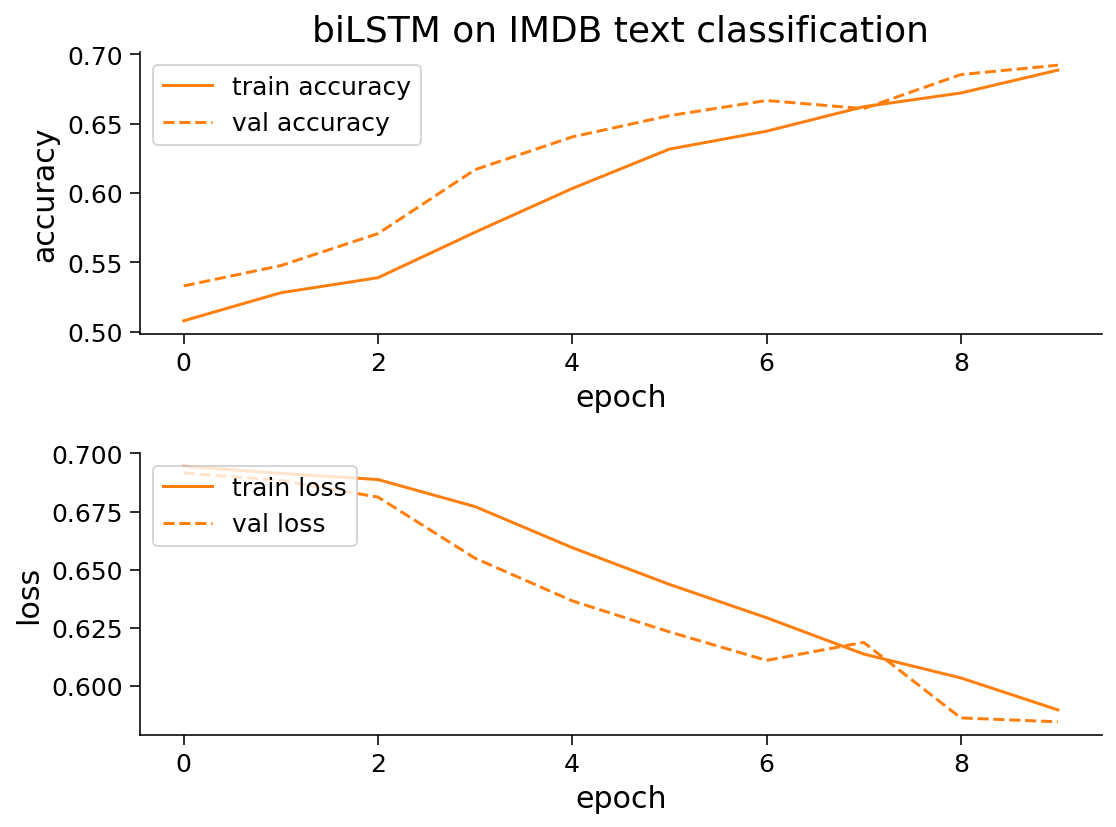

In [26]:
# Hyperparameters
learning_rate = 0.0003
output_size = 2
hidden_size = 16
embedding_length = 100
epochs = 10

# Model, training, testing
set_seed(SEED)
bilstm_model = biLSTM(output_size, hidden_size, vocab_size,
                      embedding_length, DEVICE)
bilstm_model.to(DEVICE)
bilstm_train_loss, bilstm_train_acc, bilstm_validation_loss, bilstm_validation_acc = train(bilstm_model,
                                                                                           DEVICE,
                                                                                           train_iter,
                                                                                           valid_iter,
                                                                                           epochs,
                                                                                           learning_rate)
test_accuracy = test(bilstm_model, DEVICE, test_iter)
print(f'Test Accuracy: {test_accuracy} of the biLSTM model\n')

# Plotting accuracy curve
plt.figure()
plt.subplot(211)
plot_train_val(np.arange(0, epochs), bilstm_train_acc, bilstm_validation_acc,
               'train accuracy',
               'val accuracy',
               'biLSTM on IMDB text classification',
               'accuracy',
               color='C1')
plt.legend(loc='upper left')
plt.subplot(212)
plot_train_val(np.arange(0, epochs), bilstm_train_loss, bilstm_validation_loss,
               'train loss',
               'val loss',
               '',
               'loss',
               color='C1')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

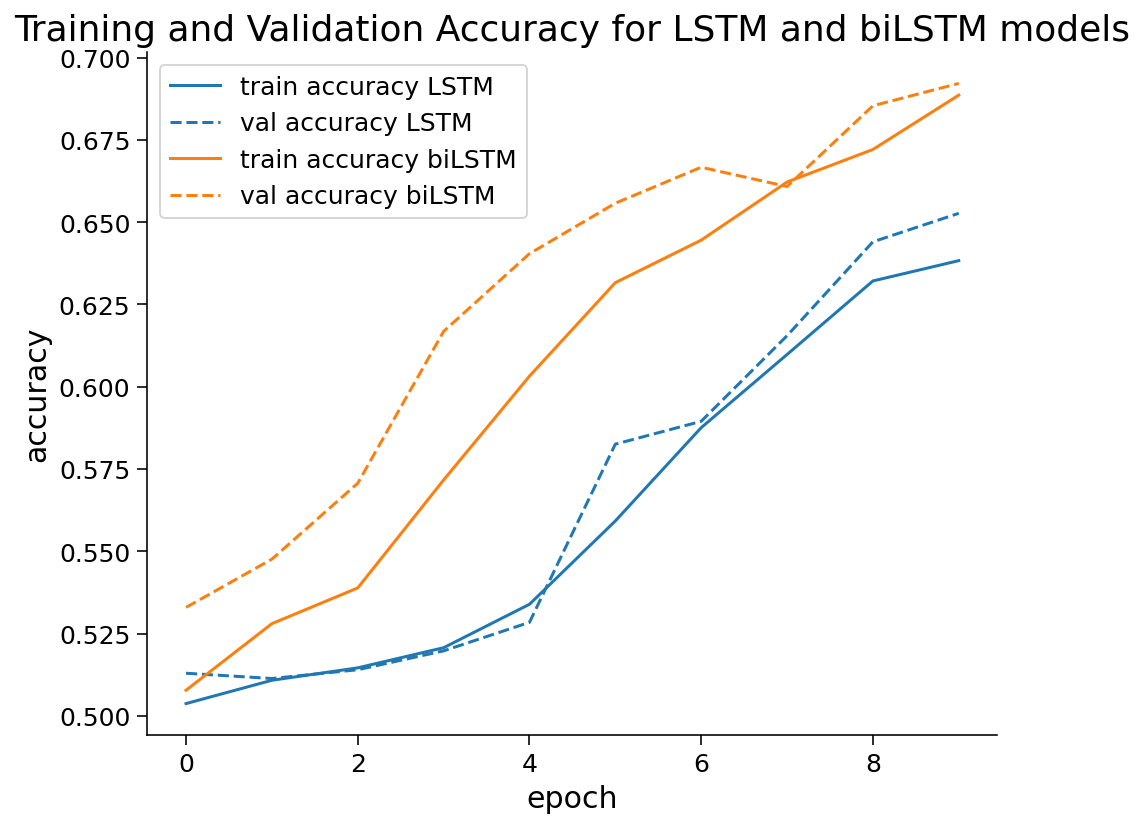

In [27]:
# Compare accuracies of LSTM and biLSTM
plot_train_val(np.arange(0, epochs), lstm_train_acc,
               lstm_validation_acc,
               'train accuracy LSTM', 'val accuracy LSTM',
               '', 'accuracy',
               color='C0')
plot_train_val(np.arange(0, epochs), bilstm_train_acc,
               bilstm_validation_acc,
               'train accuracy biLSTM', 'val accuracy biLSTM',
               'Training and Validation Accuracy for LSTM and biLSTM models',
               'accuracy',
               color='C1')
plt.legend(loc='upper left')
plt.show()

---
# Section 3: Sequence to Sequence (Seq2Seq) & Encoder/ Decoder Networks

In [28]:
# @title Video 4: Seq2Seq & Encoder-Decoder Nets
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1WM4y1N7P7", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"q-hf7mnZsXo", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

Sources: [d2l.ai on encoders](https://d2l.ai/chapter_recurrent-modern/encoder-decoder.html) ; [d2l.ai on seq2seq](https://d2l.ai/chapter_recurrent-modern/seq2seq.html) ; [Jalammar's blog](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/ )

Sequence-to-sequence models take in a sequence of items (words, characters, etc) as input and produces another sequence of items as output. The most 
simple seq2seq models are composed of two parts: the encoder, the context ("state" in the figure) and the decoder. The encoder and decoder usually consist of recurrent units that we've seen before (RNNs, GRUs or LSTMs). A high-level schematic of the architecture is as follows:

<center><img src="https://d2l.ai/_images/encoder-decoder.svg" width="500"/></center>

The encoder's recurrent unit processes the input one item at a time. Once the entire sequence is processed, the final hidden state vector produced is known as a context vector. The size of the context vector is defined while setting up the model, and is equal to the number of hidden states used in the encoder RNN. The encoder then passes the context to the decoder. The decoder's recurrent unit uses the context to produce the items for the output sequence one by one.   


One of the most popular applications of seq2seq models is "machine translation": the task of taking in a sentence in one language (the source) and producing its translation in another language (the target); with words in both lanugages being the sequence units. This is a supervised learning task, and requires the dataset to have "parallel sentences"; i.e., each sentence in the source language must be labelled with its translation in the target language. 

[Here is an intuitive visualization for understanding seq2seq models for machine translation from English to French](https://i.imgur.com/HJ6t8up.mp4)

Since the vocabulary of an entire language is very large, training such models to give meaningful performance requires significant time and resources. In this section, we will train a seq2seq model to perform machine translation from English to [Pig-Latin](https://en.wikipedia.org/wiki/Pig_Latin). We will modify the task to perform character-level machine translation, so that vocabulary size does not grow exponentially.   


## Coding Exercise 3: Encoder

Let us consider a sequence example ($batch\_size=1$). Suppose that the input sequence is $x_1, \ldots, x_T$, such that $x_t$ is the $t^{\mathrm{th}}$ token in the input text sequence. At time step $t$, the RNN transforms the input feature vector $\mathbf{x}_t$ for $x_t$ and the hidden state $\mathbf{h} _{t-1}$ from the previous time step into the current hidden state $\mathbf{h}_t$.

We can use a function $f$ to express the transformation of the RNN's recurrent layer:

\begin{equation}
\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1})
\end{equation}

In general, the encoder transforms the hidden states at all the time steps into the context variable through a customized function $q$:

\begin{equation}
\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T)
\end{equation}

For example, when choosing $q(\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$  the context variable is just the hidden state $\mathbf{h}_T$ of the input sequence at the final time step.

So far we have used a unidirectional RNN to design the encoder, where a hidden state only depends on the input subsequence at and before the time step of the hidden state. We can also construct encoders using bidirectional RNNs. In this case, a hidden state depends on the subsequence before and after the time step (including the input at the current time step), which encodes the information of the entire sequence.

Now let us implement the RNN encoder. Note that we use an *embedding layer*
to obtain the feature vector for each token in the input sequence. The weight of an embedding layer is a matrix whose number of rows is equal to the size of the input vocabulary (`vocab_size`) and the number of columns equals to the feature vector's dimension (`embed_size`). For any input token index $i$,
the embedding layer fetches the $i^{\mathrm{th}}$ row (starting from 0) of the weight matrix to return its feature vector. ere we choose a multilayer GRU to implement the encoder.

The returned variables of recurrent layers have been completely explained at [this link](https://www.d2l.ai/chapter_recurrent-neural-networks/rnn-concise.html#sec-rnn-concise). Let us still use a concrete example to illustrate the above encoder implementation. Below we instantiate a two-layer GRU encoder whose number of hidden units is 16. Given a minibatch of sequence inputs $X$ ($batch\_size=4$, $number\_of\_time\_steps=7$), the hidden states of the last layer at all the time steps (`output` returned by the encoder's recurrent layers) are a tensor of shape (number of time steps, batch size, number of hidden units).


In [29]:
class Seq2SeqEncoder(d2l.Encoder):
  """The RNN encoder for sequence to sequence learning."""
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0, **kwargs):
    super(Seq2SeqEncoder, self).__init__(**kwargs)
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Encoder Unit")
    ####################################################################
    # Embedding layer
    self.embedding = ...
    # Here you're going to implement a GRU as the RNN unit
    self.rnn = ...

  def forward(self, X, *args):
    # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
    X = self.embedding(X)
    # In RNN models, the first axis corresponds to time steps
    X = X.permute(1, 0, 2)
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Forward pass")
    ####################################################################
    # When state is not mentioned, it defaults to zeros, the output should be a RNN function of X!
    output, state = ...
    # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
    # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)

    return output, state


X = torch.zeros((4, 7), dtype=torch.long)
## uncomment the lines below.
# encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
# encoder.eval()
# output, state = encoder(X)
# print(output.shape)
# print(state.shape)

In [30]:
# to_remove solution
class Seq2SeqEncoder(d2l.Encoder):
  """The RNN encoder for sequence to sequence learning."""
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0, **kwargs):
    super(Seq2SeqEncoder, self).__init__(**kwargs)

    # Embedding layer
    self.embedding = nn.Embedding(vocab_size, embed_size)
    # Here you're going to implement a GRU as the RNN unit
    self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                      dropout=dropout)

  def forward(self, X, *args):
    # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
    X = self.embedding(X)
    # In RNN models, the first axis corresponds to time steps
    X = X.permute(1, 0, 2)
    # When state is not mentioned, it defaults to zeros, the output should be a RNN function of X!
    output, state = self.rnn(X)
    # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
    # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
    return output, state


X = torch.zeros((4, 7), dtype=torch.long)
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
output, state = encoder(X)
print(output.shape)
print(state.shape)

torch.Size([7, 4, 16])
torch.Size([2, 4, 16])


```
torch.Size([7, 4, 16])
torch.Size([2, 4, 16])
```

## Section 3.1: Decoder

As we just mentioned, the context variable $\mathbf{c}$ of the encoder's output encodes the entire input sequence $x_1, \ldots, x_T$. Given the output sequence $y_1, y_2, \ldots, y_{T'}$ from the training dataset, for each time step $t'$
(the symbol differs from the time step $t$ of input sequences or encoders),
the probability of the decoder output $y_{t'}$ is conditional on the previous output subsequence $y_1, \ldots, y_{t'-1}$ and the context variable $\mathbf{c}$, i.e., $P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$.


To model this conditional probability on sequences, we can use another RNN as the decoder. At any time step $t^\prime$ on the output sequence, the RNN takes the output $y_{t^\prime-1}$ from the previous time step and the context variable $\mathbf{c}$ as its input, then transforms them and the previous hidden state $\mathbf{s}_{t^\prime-1}$ into the hidden state $\mathbf{s}_{t^\prime}$ at the current time step.

As a result, we can use a function $g$ to express the transformation of the decoder's hidden layer:

\begin{equation}
\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1})
\end{equation}

After obtaining the hidden state of the decoder, we can use an output layer and the softmax operation to compute the conditional probability distribution
$P(y_{t^\prime} \mid y_1, \ldots, y_{t^\prime-1}, \mathbf{c})$ for the output at time step $t^\prime$.

Following `fig_seq2seq`, when implementing the decoder as follows, we directly use the hidden state at the final time step of the encoder to initialize the hidden state of the decoder.

This requires that the RNN encoder and the RNN decoder have the same number of layers and hidden units. To further incorporate the encoded input sequence information, the context variable is concatenated with the decoder input at all the time steps. To predict the probability distribution of the output token,
a fully-connected layer is used to transform the hidden state at the final layer of the RNN decoder.

In [31]:
class Seq2SeqDecoder(d2l.Decoder):
  """The RNN decoder for sequence to sequence learning."""
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0, **kwargs):
    super(Seq2SeqDecoder, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                      dropout=dropout)
    self.dense = nn.Linear(num_hiddens, vocab_size)

  def init_state(self, enc_outputs, *args):
    return enc_outputs[1]

  def forward(self, X, state):
    # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
    X = self.embedding(X).permute(1, 0, 2)
    # Broadcast `context` so it has the same `num_steps` as `X`
    context = state[-1].repeat(X.shape[0], 1, 1)
    X_and_context = torch.cat((X, context), 2)
    output, state = self.rnn(X_and_context, state)
    output = self.dense(output).permute(1, 0, 2)
    # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
    return output, state

To illustrate the implemented decoder,
below we instantiate it with the same hyperparameters from the aforementioned encoder.
As we can see, the output shape of the decoder becomes (batch size, number of time steps, vocabulary size),
where the last dimension of the tensor stores the predicted token distribution.


In [32]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
# decoder.initialize()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, len(state), state[0].shape

(torch.Size([4, 7, 10]), 2, torch.Size([4, 16]))

## Section 3.2: Loss Function

At each time step, the decoder predicts a probability distribution for the output tokens. Similar to language modeling, we can apply softmax to obtain the distribution and calculate the cross-entropy loss for optimization. Recall that the special padding tokens are appended to the end of sequences so sequences of varying lengths can be efficiently loaded in minibatches of the same shape.
However, prediction of padding tokens should be excluded from loss calculations.

To this end, we can use the following `sequence_mask` function to mask irrelevant entries with zero values so later multiplication of any irrelevant prediction with zero equals to zero. For example, if the valid length of two sequences excluding padding tokens (i.e., pads each sequence to the same length usually matching the longest sequence) are one and two, respectively, the remaining entries after the first one and the first two entries are cleared to zeros.


In [33]:
def sequence_mask(X, valid_len, value=0):
  """Mask irrelevant entries in sequences."""
  maxlen = X.size(1)
  mask = torch.arange((maxlen), dtype=torch.float32,
                      device=X.device)[None, :] < valid_len[:, None]
  X[~mask] = value
  return X


X = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(sequence_mask(X, torch.tensor([1, 2])))
X = torch.ones(2, 3, 4)
print(sequence_mask(X, torch.tensor([1, 2]), value=-1))

tensor([[1, 0, 0],
        [4, 5, 0]])
tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])


Now we can extend the softmax cross-entropy loss
to allow the masking of irrelevant predictions.
Initially,
masks for all the predicted tokens are set to one.
Once the valid length is given,
the mask corresponding to any padding token
will be cleared to zero.
In the end,
the loss for all the tokens
will be multipled by the mask to filter out
irrelevant predictions of padding tokens in the loss.


In [34]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
  """The softmax cross-entropy loss with masks."""

  # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
  # `label` shape: (`batch_size`, `num_steps`)
  # `valid_len` shape: (`batch_size`,)

  def forward(self, pred, label, valid_len):
    weights = torch.ones_like(label)
    weights = sequence_mask(weights, valid_len)
    self.reduction = 'none'
    unweighted_loss = super(MaskedSoftmaxCELoss,
                            self).forward(pred.permute(0, 2, 1), label)
    weighted_loss = (unweighted_loss * weights).mean(dim=1)

    return weighted_loss


loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10),
     torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In the following training loop,
we concatenate the special beginning-of-sequence token
and the original output sequence excluding the final token as
the input to the decoder.
This is called *teacher forcing* because
the original output sequence (token labels) is fed into the decoder.
Alternatively,
we could also feed the *predicted* token
from the previous time step
as the current input to the decoder.

In [35]:
#@title Training
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
  """Train a model for sequence to sequence."""
  def xavier_init_weights(m):
    if type(m) == nn.Linear:
      nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.GRU:
      for param in m._flat_weights_names:
        if "weight" in param:
          nn.init.xavier_uniform_(m._parameters[param])


  net.apply(xavier_init_weights)
  net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  loss = MaskedSoftmaxCELoss()
  net.train()
  animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                          xlim=[10, num_epochs])
  for epoch in range(num_epochs):
    timer = d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for batch in data_iter:
      optimizer.zero_grad()
      X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
      bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
      dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
      Y_hat, _ = net(X, dec_input, X_valid_len)
      l = loss(Y_hat, Y, Y_valid_len)
      l.sum().backward()  # Make the loss scalar for `backward`
      d2l.grad_clipping(net, 1)
      num_tokens = Y_valid_len.sum()
      optimizer.step()
      with torch.no_grad():
          metric.add(l.sum(), num_tokens)
    if (epoch + 1) % 10 == 0:
      animator.add(epoch + 1, (metric[0] / metric[1],))
  print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

Now we can create and train an RNN encoder-decoder model
for sequence to sequence learning on the machine translation dataset.


loss 0.019, 11551.4 tokens/sec on cuda


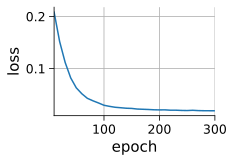

In [36]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs = 0.005, 300

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, DEVICE)

To predict the output sequence token by token, at each decoder time step
the predicted token from the previous time step is fed into the decoder as an input.

Similar to training, at the initial time step the beginning-of-sequence ("&lt;bos&gt;") token is fed into the decoder. This prediction process is illustrated in `seq2seq` figure. When the end-of-sequence ("&lt;eos&gt;") token is predicted, the prediction of the output sequence is complete.


![Predicting the output sequence token by token using an RNN encoder-decoder.](https://d2l.ai/_images/seq2seq-predict.svg)

In [37]:
# @title Prediction
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
  """Predict for sequence to sequence."""
  # Set `net` to eval mode for inference
  net.eval()
  src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
      src_vocab['<eos>']]
  enc_valid_len = torch.tensor([len(src_tokens)], device=device)
  src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
  # Add the batch axis
  enc_X = torch.unsqueeze(
      torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
  enc_outputs = net.encoder(enc_X, enc_valid_len)
  dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
  # Add the batch axis
  dec_X = torch.unsqueeze(
      torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),
      dim=0)
  output_seq, attention_weight_seq = [], []
  for _ in range(num_steps):
    Y, dec_state = net.decoder(dec_X, dec_state)
    # We use the token with the highest prediction likelihood as the input
    # of the decoder at the next time step
    dec_X = Y.argmax(dim=2)
    pred = dec_X.squeeze(dim=0).type(torch.int32).item()
    # Save attention weights (to be covered later)
    if save_attention_weights:
        attention_weight_seq.append(net.decoder.attention_weights)
    # Once the end-of-sequence token is predicted, the generation of the
    # output sequence is complete
    if pred == tgt_vocab['<eos>']:
        break
    output_seq.append(pred)
  return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

We can evaluate a predicted sequence by comparing it with the label sequence (the ground-truth). BLEU (Bilingual Evaluation Understudy), though originally proposed for evaluating machine translation results in [Papieni et al., 2002](https://dl.acm.org/doi/10.3115/1073083.1073135), has been extensively used in measuring the quality of output sequences for different applications.

In principle, for any $n$-grams in the predicted sequence, BLEU evaluates whether this $n$-grams appears in the label sequence.

Denote by $p_n$ the precision of $n$-grams, which is the ratio of the number of matched $n$-grams in the predicted and label sequences to the number of $n$-grams in the predicted sequence.
To explain, given a label sequence $A$, $B$, $C$, $D$, $E$, $F$, and a predicted sequence $A$, $B$, $B$, $C$, $D$, we have $p_1 = 4/5$,  $p_2 = 3/4$, $p_3 = 1/3$, and $p_4 = 0$.

Besides, let $\mathrm{len}_{\text{label}}$ and $\mathrm{len}_{\text{pred}}$
be the numbers of tokens in the label sequence and the predicted sequence, respectively.

Then, BLEU is defined as

\begin{equation}
\exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},
\end{equation}

where $k$ is the longest $n$-grams for matching.

Based on the definition of BLEU in the above equation, whenever the predicted sequence is the same as the label sequence, BLEU is 1.

Moreover, since matching longer $n$-grams is more difficult, BLEU assigns a greater weight to a longer $n$-gram precision. Specifically, when $p_n$ is fixed, $p_n^{1/2^n}$ increases as $n$ grows (the original paper uses $p_n^{1/n}$).

Furthermore, since predicting shorter sequences tends to obtain a higher $p_n$ value, the coefficient before the multiplication term in the above equation
penalizes shorter predicted sequences.

For example, when $k=2$, given the label sequence $A$, $B$, $C$, $D$, $E$, $F$ and the predicted sequence $A$, $B$, although $p_1 = p_2 = 1$, the penalty factor $\exp(1-6/2) \approx 0.14$ lowers the BLEU.

We implement the BLEU measure as follows.


In [38]:
#@title Evaluation of Predicted Sequences
def bleu(pred_seq, label_seq, k):
  """Compute the BLEU."""
  pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
  len_pred, len_label = len(pred_tokens), len(label_tokens)
  score = math.exp(min(0, 1 - len_label / len_pred))
  for n in range(1, k + 1):
    num_matches, label_subs = 0, collections.defaultdict(int)
    for i in range(len_label - n + 1):
      label_subs[''.join(label_tokens[i:i + n])] += 1
    for i in range(len_pred - n + 1):
      if label_subs[''.join(pred_tokens[i:i + n])] > 0:
        num_matches += 1
        label_subs[''.join(pred_tokens[i:i + n])] -= 1
    score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
  return score

In the end,
we use the trained RNN encoder-decoder
to translate a few English sentences into French
and compute the BLEU of the results.


In [39]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
# fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
fras = [ 'je suis chez moi .', 'j\'ai perdu .','va !', 'il est calme .']
for eng, fra in zip(engs, fras):
  translation, attention_weight_seq = predict_seq2seq(net,
                                                      eng,
                                                      src_vocab,
                                                      tgt_vocab,
                                                      num_steps,
                                                      DEVICE)
  print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va au, bleu 0.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est <unk> ., bleu 0.000
i'm home . => je suis calme chez <unk> ., bleu 0.000


---
# Section 4: Attention


 

In [40]:
# @title Video 5: Attention mechanisms
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Mo4y1S7oK", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"Vt9GhJKcEiM", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

Previously, we designed an encoder-decoder architecture based on two RNNs for sequence to sequence learning. Specifically, the RNN encoder transforms a variable-length sequence into a fixed-shape context variable, then the RNN decoder generates the output (target) sequence token by token based on the generated tokens and the context variable. However, even though not all the input (source) tokens are useful for decoding a certain token, the same context variable that encodes the entire input sequence is still used at each decoding step. It is challenging for the models to deal with long sentences. 

In [Bahdanau et al., 2014](https://arxiv.org/abs/1409.0473), the authors proposed a technique called attention. When predicting a token, if not all the input tokens are relevant, the model aligns (or attends) only to parts of the input sequence that are relevant to the current prediction. 


In contrast to seq2seq model, the encoder passes a lot more data to the decoder. Instead of passing the last hidden state of the encoding stage, the encoder passes all the hidden states to the decoder. 

In order to focus on the parts of input relevant to the decoder, look at the set of encoder hidden states it received. Each encoder hidden state is at most associated with a certain word in the input sentence. We can assign each hidden state a score and multiply it with the softmaxed score, thus amplifying hidden states with high scores, and drowning out hidden states with low scores.


Reference Links: \\
 https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/ \\

 https://d2l.ai/chapter_attention-mechanisms/attention-cues.html

In [41]:
# @markdown Media 1: Sequence to Sequence model with Attention

url = "https://jalammar.github.io/images/seq2seq_7.mp4"
from IPython.display import HTML
HTML(f"""<video src={url} width=750 controls/>""")

In [42]:
# @markdown Media 2: Mapping input to output

url = "https://jalammar.github.io/images/seq2seq_9.mp4"
from IPython.display import HTML
HTML(f"""<video src={url} width=750 controls/>""")

## Section 4.1: Queries, Keys, and Values


To calculate the attention mechanism we make use of Queries, Keys and Values. But what are Queries, Keys and Values? Query, Value and Key are the transformations of the input vector. 

In an attention mechanism the context vector is computed as a weighted sum of values, where the weight assigned to each value is computed through an attention score. The score is usually the dot product between the query and key. The scores then go through the softmax function to yield a set of weights whose sum equals 1.

The query is from the decoder hidden state whereas the key and value are from the encoder hidden state. 


Take a minute and look at this [article](https://www.kdnuggets.com/2021/01/attention-mechanism-deep-learning-explained.html). It has detailed graphical explanation on how to calculate attention scores. 

### Coding Exercise 4.1: Attention for Text Classification

Until now, we looked at attention aimed at seq2seq networks. Let’s try implementing attention for the above IMDB sentiment analysis dataset. Previously, using the LSTM, the classification completely depended on the last hidden state. In this exercise, we will compute the attention scores between the last hidden state and output of each sequence. The final attention vector will be the weighted average of the outputs at each sequence, with the weights being the attention scores. Lastly, we will concatenate the attention vector and the last hidden state to get the final output.

For simplicity's sake, let's implement attention over an LSTM with 1 layer.


[*Code reference*](https://github.com/prakashpandey9/Text-Classification-Pytorch/blob/master/main.py)


In [43]:
class AttentionModel(torch.nn.Module):
  def __init__(self, batch_size, output_size, hidden_size, vocab_size,
               embedding_length, weights):
    super(AttentionModel, self).__init__()
    self.hidden_size = hidden_size
    self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
    self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)
    self.lstm = nn.LSTM(embedding_length, hidden_size)
    self.fc1 = nn.Linear(2*hidden_size, output_size)

  def attention_net(self, lstm_output, final_state):
    """
    lstm_output : shape: (num_seq, batch_size, hidden_size)
    final_state : shape: (1, batch_size, hidden_size)
    """
    ####################################################
    # Implement the attenion net
    # Fill in missing code below (...)
    raise NotImplementedError("perform the convolution")
    ####################################################
    # permute the output to get the shape (batch_size, num_seq, hidden_size)
    # Get the attention weights
    # use torch.bmm to compute the attention weights between each output and last hidden state
    # pay attention to the tensor shapes, you may have to use squeeze and unsqueeze functions
    # softmax the attention weights
    # Get the new hidden state, use torch.bmm to get the weighted lstm output
    # pay attention to the tensor shapes, you may have to use squeeze and unsqueeze functions
    lstm_output = ...
    hidden = ...
    attn_weights = ...  # expected shape: (batch_size, num_seq)
    soft_attn_weights = ...
    new_hidden_state = ...

    return new_hidden_state

  def forward(self, input_sentences):

    input = self.word_embeddings(input_sentences)
    input = input.permute(1, 0, 2)

    h_0 = Variable(torch.zeros(1, input.shape[1], self.hidden_size).cuda())
    c_0 = Variable(torch.zeros(1, input.shape[1], self.hidden_size).cuda())

    output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
    attn_output = self.attention_net(output, final_hidden_state)
    final_output = torch.cat((attn_output, final_hidden_state[0]), 1)
    logits = self.fc1(final_output)

    return logits


# Uncomment to check AttentionModel class
# attention_model = AttentionModel(32, 2, 16, 20, 200, TEXT.vocab.vectors)
# print(attention_model)

In [44]:
#to_remove solution
class AttentionModel(torch.nn.Module):
  def __init__(self, batch_size, output_size, hidden_size, vocab_size,
               embedding_length, weights):
    super(AttentionModel, self).__init__()
    self.hidden_size = hidden_size
    self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
    self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)
    self.lstm = nn.LSTM(embedding_length, hidden_size)
    self.fc1 = nn.Linear(2*hidden_size, output_size)

  def attention_net(self, lstm_output, final_state):
    """
    lstm_output : shape: (num_seq, batch_size, hidden_size)
    final_state : shape: (1, batch_size, hidden_size)
    """
    # permute the output to get the shape (batch_size, num_seq, hidden_size)
    # Get the attention weights
    # use torch.bmm to compute the attention weights between each output and last hidden state
    # pay attention to the tensor shapes, you may have to use squeeze and unsqueeze functions
    # softmax the attention weights
    # Get the new hidden state, use torch.bmm to get the weighted lstm output
    # pay attention to the tensor shapes, you may have to use squeeze and unsqueeze functions
    lstm_output = lstm_output.permute(1, 0, 2)
    hidden = final_state.squeeze(0)
    attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)  # expected shape: (batch_size, num_seq)
    soft_attn_weights = F.softmax(attn_weights, 1)
    new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)

    return new_hidden_state

  def forward(self, input_sentences):

    input = self.word_embeddings(input_sentences)
    input = input.permute(1, 0, 2)

    h_0 = Variable(torch.zeros(1, input.shape[1], self.hidden_size).cuda())
    c_0 = Variable(torch.zeros(1, input.shape[1], self.hidden_size).cuda())

    output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
    attn_output = self.attention_net(output, final_hidden_state)
    final_output = torch.cat((attn_output, final_hidden_state[0]), 1)
    logits = self.fc1(final_output)

    return logits


# Uncomment to check AttentionModel class
attention_model = AttentionModel(32, 2, 16, 20, 200, TEXT.vocab.vectors)
print(attention_model)

AttentionModel(
  (word_embeddings): Embedding(20, 200)
  (lstm): LSTM(200, 16)
  (fc1): Linear(in_features=32, out_features=2, bias=True)
)


```
AttentionModel(
  (word_embeddings): Embedding(20, 200)
  (lstm): LSTM(200, 16)
  (fc1): Linear(in_features=32, out_features=2, bias=True)
)
```

In [45]:
# @markdown Reload dataset using the default params since variables have been overwritten
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(seed=SEED)

Data loading is completed. Sentence length: 50, Batch size: 32, and seed: 2021


In [46]:
learning_rate = 0.0001
batch_size = 16  # initially was 32
output_size = 2
hidden_size = 16
embedding_length = 300
epochs = 6  # initially was 12

word_embeddings = TEXT.vocab.vectors
vocab_size = len(TEXT.vocab)

attention_model = AttentionModel(batch_size,
                                 output_size,
                                 hidden_size,
                                 vocab_size,
                                 embedding_length,
                                 word_embeddings)
attention_model.to(DEVICE)
attention_start_time = time.time()
set_seed(SEED)
attention_train_loss, attention_train_acc, attention_validation_loss, attention_validation_acc = train(attention_model,
                                                                                                       DEVICE,
                                                                                                       train_iter,
                                                                                                       valid_iter,
                                                                                                       epochs,
                                                                                                       learning_rate)
print("--- Time taken to train = %s seconds ---" % (time.time() - attention_start_time))
test_accuracy = test(attention_model, DEVICE, test_iter)
print(f'\n\nTest Accuracy: {test_accuracy}%')

Random seed 2021 has been set.
Epoch: 1, Training Loss: 0.6927, Training Accuracy:  52.15%
Validation Loss: 0.6895, Validation Accuracy:  52.97%
Epoch: 2, Training Loss: 0.6806, Training Accuracy:  56.90%
Validation Loss: 0.6824, Validation Accuracy:  56.20%
Epoch: 3, Training Loss: 0.6686, Training Accuracy:  60.25%
Validation Loss: 0.6751, Validation Accuracy:  57.72%
Epoch: 4, Training Loss: 0.6537, Training Accuracy:  63.48%
Validation Loss: 0.6668, Validation Accuracy:  59.21%
Epoch: 5, Training Loss: 0.6355, Training Accuracy:  65.85%
Validation Loss: 0.6574, Validation Accuracy:  60.91%
Epoch: 6, Training Loss: 0.6130, Training Accuracy:  68.61%
Validation Loss: 0.6471, Validation Accuracy:  62.25%
--- Time taken to train = 34.08147215843201 seconds ---


Test Accuracy: 62.288%


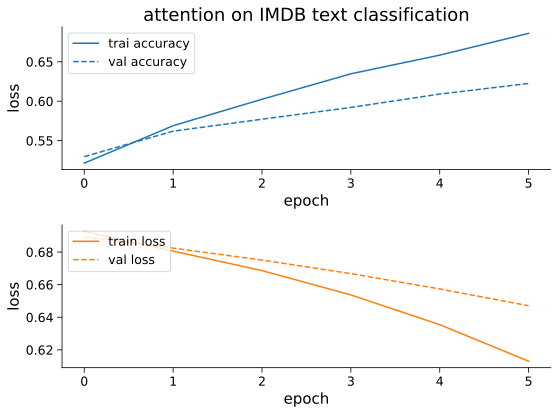

In [47]:
plt.figure()
plt.subplot(211)
plot_train_val(np.arange(0, epochs),
               attention_train_acc,
               attention_validation_acc,
               'trai accuracy',
               'val accuracy',
               'attention on IMDB text classification',
               'loss',
               color='C0')
plt.legend(loc='upper left')
plt.subplot(212)
plot_train_val(np.arange(0, epochs),
               attention_train_loss,
               attention_validation_loss,
               'train loss',
               'val loss',
               '',
               'loss',
               color='C1')
plt.tight_layout()
plt.legend(loc='upper left')

---
# Section 5: Ethical aspects

In [48]:
# @title Video 6: Ethics of Representation and Generation
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1v54y1J7SC", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"2ULMWtaGQrQ", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

---
# Summary

During this day, we have learned about modern RNNs and their variants. Now let's see some ethical aspects of representation and Generation, and then we will close the tutorials with an overview.

In [49]:
# @title Video 7: Beyond Sequence
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1864y1x7Ek", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"lVcpMSJileA", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)